## Importing the libraries and gathering the dataset

In [ ]:
# !pip install -q librosa
# !wget -q https://github.com/karoldvl/ESC-50/archive/master.zip
# !unzip -q master.zip
!pip install resampy

import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0

  Using cached resampy-0.4.3-py3-none-any.whl.metadata (3.0 kB)
Using cached resampy-0.4.3-py3-none-any.whl (3.1 MB)


In [ ]:
### Load metadata
meta_df = pd.read_csv('ESC-50-master/meta/esc50.csv')
TARGET_SIZE = (224, 224) # Input size for EfficientNetB0

def extract_features_3channel(file_path):
  """
  Extracts a log-mel-spectrogram and converts it to a 3-channel image.
  """
  try:
      audio, sr = librosa.load(file_path, res_type='kaiser_fast', duration=5, sr=22050)

      # 1. Create the mel-spectrogram
      spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
      spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

      # 2. Resize to the target size for the pre-trained model
      spectrogram_resized = tf.image.resize(np.expand_dims(spectrogram, axis=-1), TARGET_SIZE)

      # 3. Convert grayscale to 3-channel by stacking
      spectrogram_3channel = np.concatenate([spectrogram_resized, spectrogram_resized, spectrogram_resized], axis=-1)

      return spectrogram_3channel

  except Exception as e:
      print(f"Error processing {file_path}: {e}")
      return None

In [ ]:
## Process the audio files
features = []
labels = []
audio_dir = 'ESC-50-master/audio/'

for index, row in tqdm(meta_df.iterrows(), total=meta_df.shape[0]):
    file_path = audio_dir + row['filename']
    spec = extract_features_3channel(file_path)
    if spec is not None:
        features.append(spec)
        labels.append(row['category'])

X = np.array(features)
y = np.array(labels)

100%|██████████| 2000/2000 [03:32<00:00,  9.39it/s]


In [ ]:
## Prepare the data
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot)


### Transfer learning model

In [ ]:
input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
num_classes = len(label_encoder.classes_)

# Load the pre-trained base model (without its top classification layer)
base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

# Build our new model on top of the frozen base
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),             # Regularization
    Dense(num_classes, activation='softmax') # Our classification layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        64,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,113,621 (15.69 MB)

 Trainable params: 64,050 (250.20 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Now we have a pre trained model with 4 million non trainable params and 64 thousand trainable params

### Training the classification head

We will train only the new layers we added on top of `EfficientNetB0`. The entire pre-trained base will remain frozen. This step quickly teaches our model how to map the powerful, pre-existing features from `EfficientNetB0` to our 50 specific sound classes.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

## reduce learning rate if val_loss doesn't improve for 5 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

num_epochs_phase1 = 100
batch_size = 32

## Classification head
history_tl_phase1 = model.fit(
    X_train,
    y_train,
    epochs=num_epochs_phase1,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6670 - loss: 1.1947 - val_accuracy: 0.6275 - val_loss: 1.3441 - learning_rate: 1.0000e-05
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6361 - loss: 1.2658 - val_accuracy: 0.6300 - val_loss: 1.3413 - learning_rate: 1.0000e-05
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6168 - loss: 1.3070 - val_accuracy: 0.6300 - val_loss: 1.3399 - learning_rate: 1.0000e-05
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6842 - loss: 1.1323 - val_accuracy: 0.6325 - val_loss: 1.3393 - learning_rate: 1.0000e-05
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6393 - loss: 1.2388 - val_accuracy: 0.6325 - val_loss: 1.3367 - learning_rate: 1.0000e-05
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6235 - loss: 1.2971 - val_accuracy: 0.6325 - val_loss: 1.3341 - learning_rate: 1.0000e-05
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 

In [ ]:
## Evaluating the classification head model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy after Phase 1: {test_acc*100:.2f}%")

Test Accuracy after Phase 1: 66.25%


The model has learned the basic mapping. Now, we will "unfreeze" the top layers of the `EfficientNetB0` base model. This allows the model to slightly adjust its more specialized, high-level feature detectors to better fit the unique patterns in our spectrograms. We must use a very low learning rate for this step. If the learning rate is too high, it will erase the valuable knowledge stored in the pre-trained weights.

In [ ]:
# Unfreeze the model
base_model.trainable = True
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 238


We'll unfreeze the top layers and keep the early ones frozen. This prevents the model from forgetting its basic feature knowledge (like edge detection). A common practice is to unfreeze the top 20-30% of layers.

In [ ]:
fine_tune_at = -80  # Unfreeze the last 80 layers

## Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Recompile the model with low learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        64,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,113,621 (15.69 MB)

 Trainable params: 2,590,914 (9.88 MB)

 Non-trainable params: 1,522,707 (5.81 MB)

Now, we can see increased trainable parms

In [ ]:
## Fine tuning
fine_tune_epochs = 50

# Continue from the epochs we already trained
total_epochs = num_epochs_phase1 + fine_tune_epochs

# Continue training the model
history_tl_phase2 = model.fit(
    X_train,
    y_train,
    epochs=total_epochs,
    initial_epoch=history_tl_phase1.epoch[-1], # Start from where we left off
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr] # same callbacks
)

Epoch 100/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 323ms/step - accuracy: 0.7604 - loss: 0.8055 - val_accuracy: 0.6650 - val_loss: 1.1721 - learning_rate: 1.0000e-05
Epoch 101/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7628 - loss: 0.8713 - val_accuracy: 0.6750 - val_loss: 1.1696 - learning_rate: 1.0000e-05
Epoch 102/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7414 - loss: 0.8643 - val_accuracy: 0.6675 - val_loss: 1.1649 - learning_rate: 1.0000e-05
Epoch 103/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7354 - loss: 0.9351 - val_accuracy: 0.6700 - val_loss: 1.1613 - learning_rate: 1.0000e-05
Epoch 104/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7641 - loss: 0.8084 - val_accuracy: 0.6675 - val_loss: 1.1645 - learning_rate: 1.0000e-05
Epoch 105/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.7781 - loss: 0.7831 - val_accuracy: 0.6675 - val_loss: 1.1623 - learning_rate: 1.0000e-05
Epoch 106/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/s

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

Final Test Accuracy: 68.75%
Final Test Loss: 1.1292


### Evaluating

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print(f"Final Test Accuracy: {model.evaluate(X_test, y_test, verbose=0)[1]*100:.2f}%")

y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
class_names = label_encoder.classes_

print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

Final Test Accuracy: 68.75%
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 550ms/step
                  precision    recall  f1-score   support

        airplane       0.83      0.62      0.71         8
       breathing       0.50      0.38      0.43         8
  brushing_teeth       0.88      0.88      0.88         8
     can_opening       0.35      0.75      0.48         8
        car_horn       1.00      0.50      0.67         8
             cat       1.00      0.62      0.77         8
        chainsaw       0.88      0.88      0.88         8
  chirping_birds       0.78      0.88      0.82         8
    church_bells       0.64      0.88      0.74         8
        clapping       0.67      0.50      0.57         8
     clock_alarm       0.78      0.88      0.82         8
      clock_tick       0.78      0.88      0.82         8
        coughing       0.67      0.25      0.36         8
             cow       1.00      0.75      0.86         8
  crackling_fire       0.56      0.62      0.59         8
 

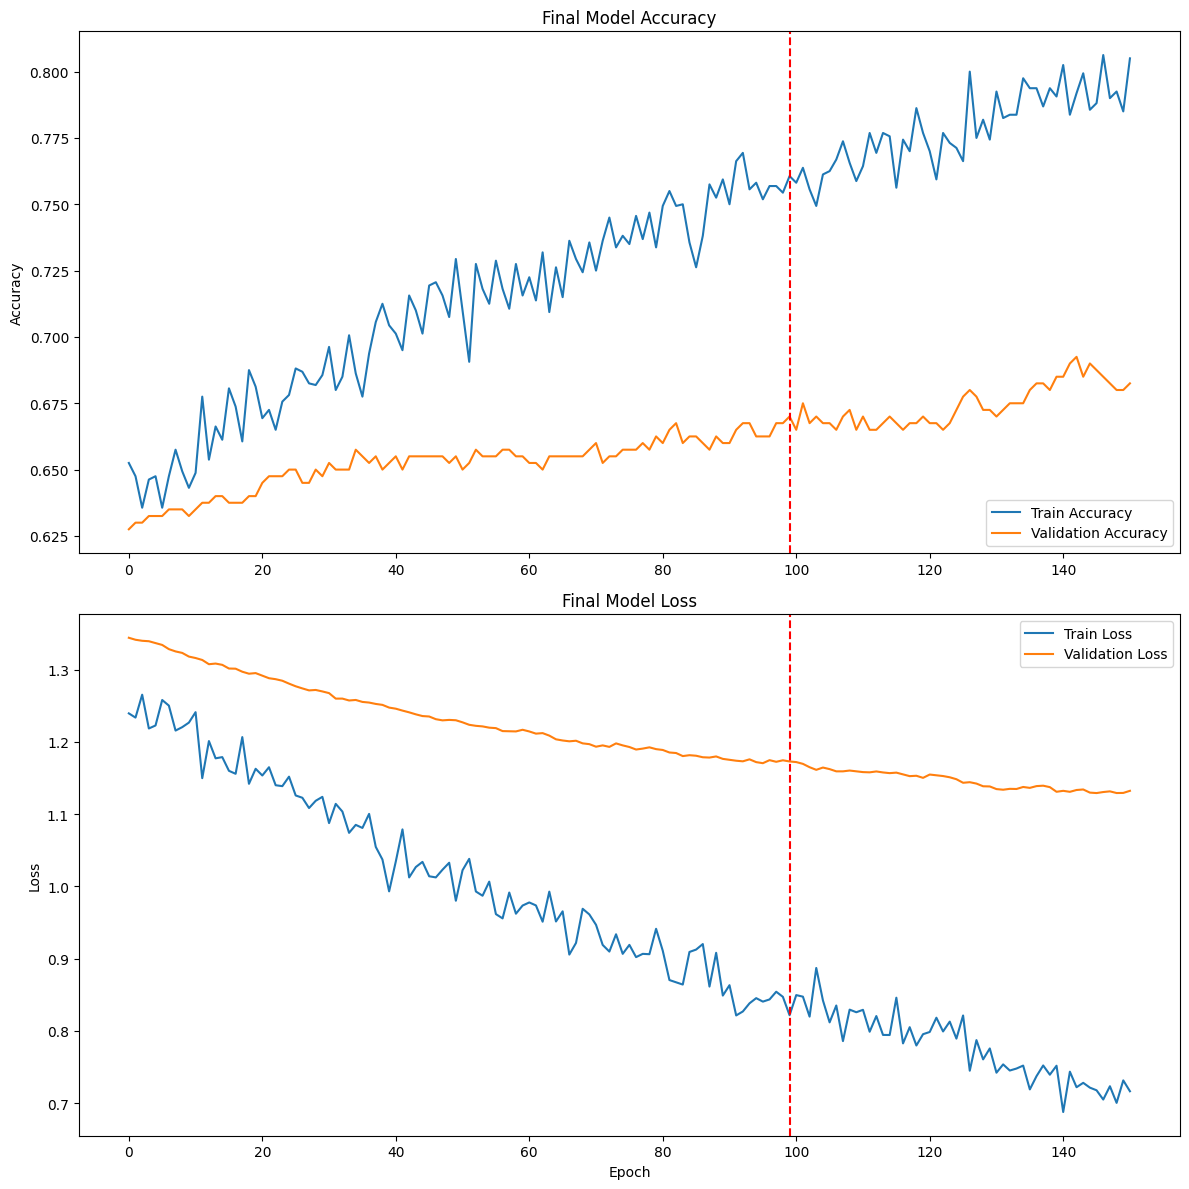

In [ ]:
history_phase1 = history_tl_phase1
history_phase2 = history_tl_phase2

# Combine the history from both training phases
acc = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
val_acc = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

# Create the plots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot accuracy
axs[0].plot(acc, label='Train Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].set_title('Final Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].axvline(x=len(history_phase1.history['accuracy'])-1, color='r', linestyle='--', label='Start Fine-Tuning')


# Plot loss
axs[1].plot(loss, label='Train Loss')
axs[1].plot(val_loss, label='Validation Loss')
axs[1].set_title('Final Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')
axs[1].axvline(x=len(history_phase1.history['loss'])-1, color='r', linestyle='--', label='Start Fine-Tuning')

plt.tight_layout()
plt.show()

In [ ]:
## Saving the results
import pickle

model.save('echosense_champion_model.keras')

with open('echosense_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
